In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
df = pd.read_csv('../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

torch.manual_seed(42)

from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [4]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [5]:
first_piece['timestamp'] = first_piece.index
first_piece
second_piece['timestamp'] = second_piece.index

/tmp/ipykernel_6954/1198399534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_piece['timestamp'] = first_piece.index
/tmp/ipykernel_6954/1198399534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_piece['timestamp'] = second_piece.index


In [6]:
from gluonts.dataset.util import to_pandas
freq="5min"

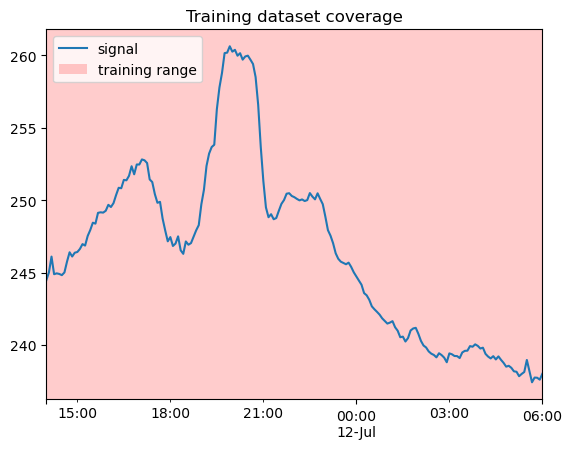

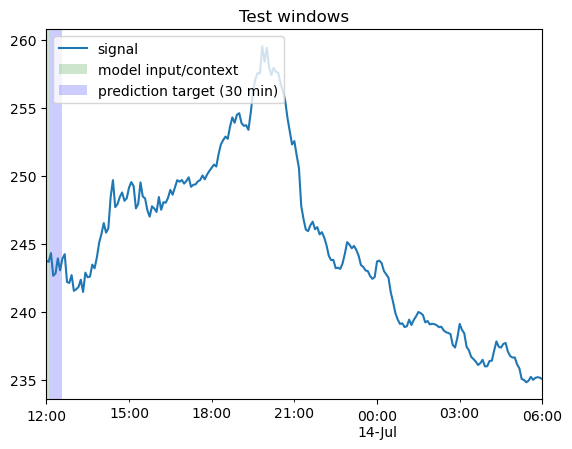

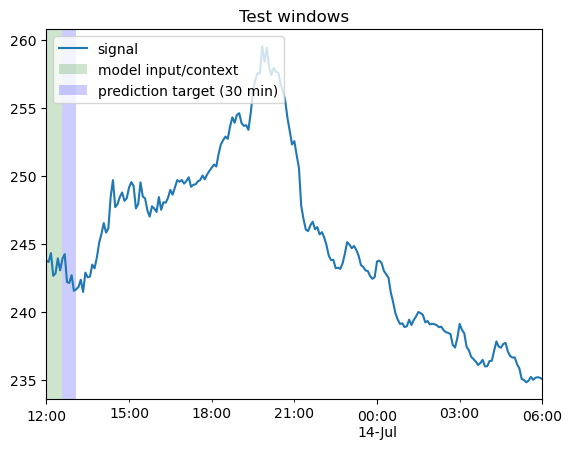

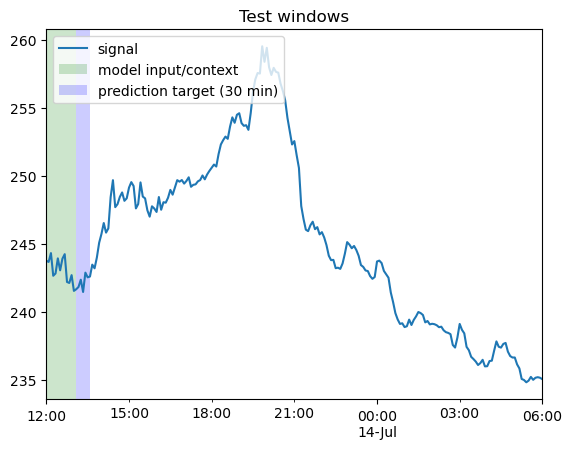

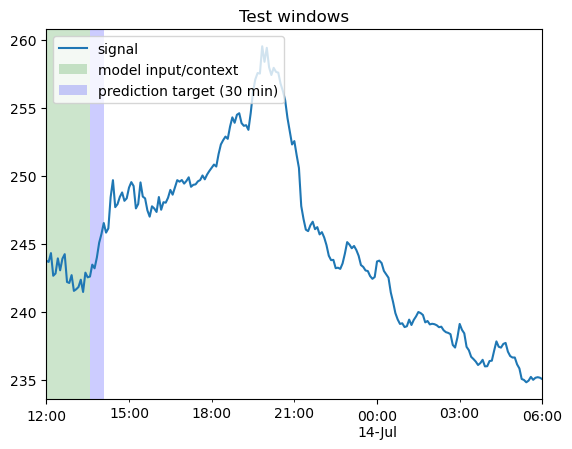

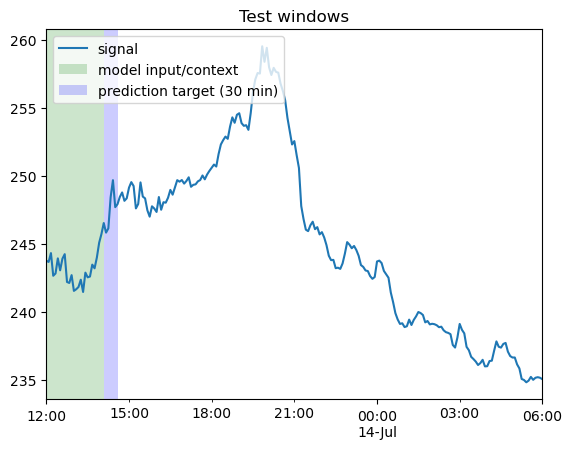

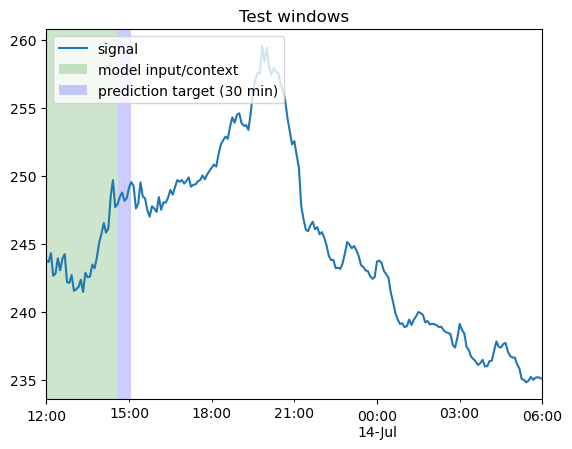

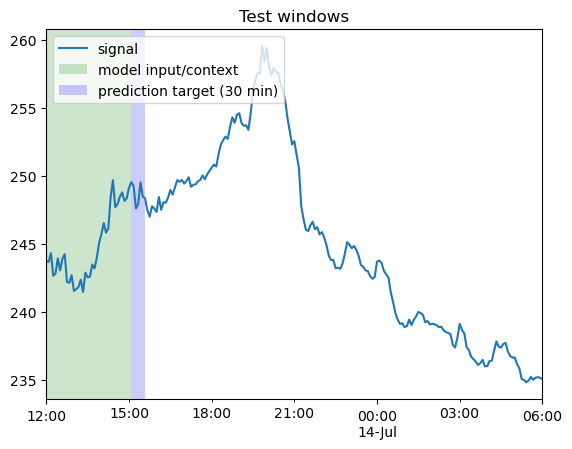

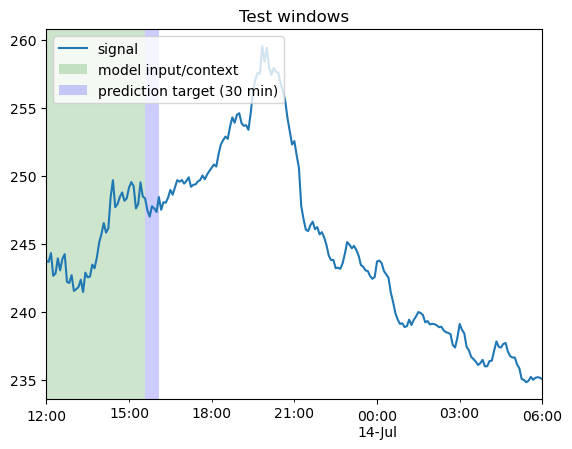

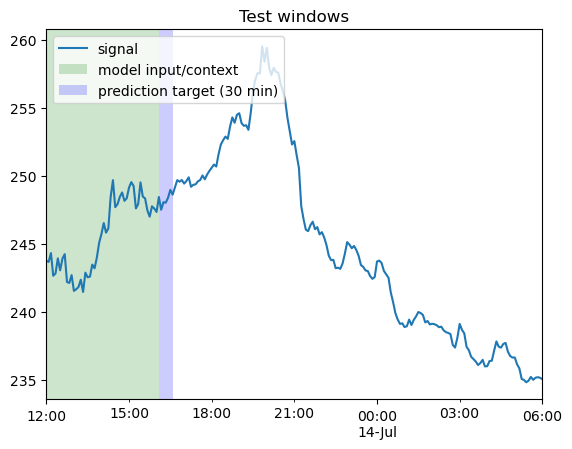

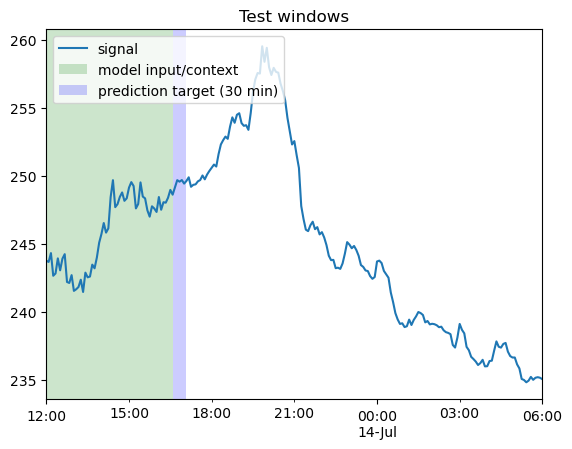

In [7]:
# wrap first_piece and second_piece separately
train_full = PandasDataset(
    dataframes=first_piece,
    freq=freq,
    target="O2_avg",
    timestamp="timestamp",
)

test_full = PandasDataset(
    dataframes=second_piece,
    freq=freq,
    target="O2_avg",
    timestamp="timestamp",
)

# now: create a "test template" *from the test_full dataset*
# choose a split point inside second_piece where you want forecasting to start.
# usually that's just the start of second_piece if you want to forecast all of it.
# So we split right at the first timestamp of second_piece.

prediction_length = 6  # 6 * 5min = 30 minutes
test_start_period = pd.Period(
    second_piece["timestamp"].iloc[0],
    freq=freq
)

_, test_template = split(
    test_full,
    date=test_start_period
)

# NOW we can call generate_instances on test_template
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=10,
)

############################################
# 2. Helper: PeriodIndex -> DatetimeIndex
############################################
def _to_datetime_index(s_or_df):
    obj = s_or_df.copy()
    if isinstance(obj.index, pd.PeriodIndex):
        obj.index = obj.index.to_timestamp()  # cast PeriodIndex -> DatetimeIndex
    return obj

############################################
# 3. Shading helper for visualization
############################################
def highlight_entry(entry, color, label=None):
    """
    entry["start"] is a pandas.Period
    entry["target"] is array-like of values
    We shade from the first timestamp covered by this entry
    to the timestamp immediately after the last step.
    """
    start_period = entry["start"]
    n = int(len(entry["target"]))
    left = start_period.to_timestamp()
    right = (start_period + n).to_timestamp()
    plt.axvspan(left, right, facecolor=color, alpha=0.2, label=label)

############################################
# 4. Make windows from the test dataset
############################################
# You said: windows of length 30 min.
# Your freq is 5min, so 30 min = 6 steps.


############################################
# 5. Plotting
############################################
def plot_train_and_test_windows(train_dataset, test_dataset, test_pairs):
    # Plot training dataset coverage (red)
    for original_entry, train_entry in zip(train_dataset, train_dataset):
        s = _to_datetime_index(to_pandas(original_entry))
        ax = s.plot()
        highlight_entry(train_entry, "red", label="training range")
        ax.legend(["signal", "training range"], loc="upper left")
        plt.title("Training dataset coverage")
        plt.show()

    # Plot each (context, label) window on top of the test series
    for original_entry in test_dataset:
        s = _to_datetime_index(to_pandas(original_entry))
        for test_input, test_label in test_pairs:
            ax = s.plot()
            highlight_entry(test_input, "green", label="model input/context")
            highlight_entry(test_label, "blue", label="prediction target (30 min)")
            ax.legend(
                ["signal", "model input/context", "prediction target (30 min)"],
                loc="upper left",
            )
            plt.title("Test windows")
            plt.show()

############################################
# 6. Call the plotting function
############################################
plot_train_and_test_windows(train_full, test_full, test_pairs)

In [8]:
estimator = DeepAREstimator(
    freq="5min",
    prediction_length=prediction_length,
    trainer_kwargs={"max_epochs": 50}
)

predictor = estimator.train(train_full)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/raman-pc/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-10-26 23:27:07.364949: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-26 23:27:07.371641: E 

Epoch 0: |          | 50/? [00:01<00:00, 35.72it/s, v_num=20, train_loss=5.980]

Epoch 0, global step 50: 'train_loss' reached 5.98178 (best 5.98178), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_20/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 38.76it/s, v_num=20, train_loss=3.580]

Epoch 1, global step 100: 'train_loss' reached 3.57877 (best 3.57877), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_20/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 36.95it/s, v_num=20, train_loss=3.060]

Epoch 2, global step 150: 'train_loss' reached 3.05858 (best 3.05858), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_20/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 37.39it/s, v_num=20, train_loss=3.110]

Epoch 3, global step 200: 'train_loss' was not in top 1


Epoch 4: |          | 50/? [00:01<00:00, 37.69it/s, v_num=20, train_loss=2.920]

Epoch 4, global step 250: 'train_loss' reached 2.92455 (best 2.92455), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_20/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:01<00:00, 37.08it/s, v_num=20, train_loss=2.780]

Epoch 5, global step 300: 'train_loss' reached 2.77708 (best 2.77708), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_20/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:01<00:00, 38.01it/s, v_num=20, train_loss=2.650]

Epoch 6, global step 350: 'train_loss' reached 2.65366 (best 2.65366), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_20/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:01<00:00, 38.08it/s, v_num=20, train_loss=2.320]

Epoch 7, global step 400: 'train_loss' reached 2.31624 (best 2.31624), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_20/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:02<00:00, 19.82it/s, v_num=20, train_loss=2.680]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 38.00it/s, v_num=20, train_loss=2.410]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 37.75it/s, v_num=20, train_loss=2.870]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: |          | 50/? [00:01<00:00, 40.33it/s, v_num=20, train_loss=2.870]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 39.17it/s, v_num=20, train_loss=2.610]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 39.46it/s, v_num=20, train_loss=2.560]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 38.80it/s, v_num=20, train_loss=2.520]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 41.03it/s, v_num=20, train_loss=2.660]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 40.82it/s, v_num=20, train_loss=2.590]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 38.28it/s, v_num=20, train_loss=2.550]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 41.04it/s, v_num=20, train_loss=2.560]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 40.73it/s, v_num=20, train_loss=2.070]

Epoch 19, global step 1000: 'train_loss' reached 2.07101 (best 2.07101), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_20/checkpoints/epoch=19-step=1000.ckpt' as top 1


Epoch 20: |          | 50/? [00:01<00:00, 40.38it/s, v_num=20, train_loss=2.040]

Epoch 20, global step 1050: 'train_loss' reached 2.03616 (best 2.03616), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_20/checkpoints/epoch=20-step=1050.ckpt' as top 1


Epoch 21: |          | 50/? [00:01<00:00, 36.37it/s, v_num=20, train_loss=2.080]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 35.38it/s, v_num=20, train_loss=2.210]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 35.11it/s, v_num=20, train_loss=1.980]

Epoch 23, global step 1200: 'train_loss' reached 1.98237 (best 1.98237), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_20/checkpoints/epoch=23-step=1200.ckpt' as top 1


Epoch 24: |          | 50/? [00:01<00:00, 34.52it/s, v_num=20, train_loss=1.960]

Epoch 24, global step 1250: 'train_loss' reached 1.95848 (best 1.95848), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_20/checkpoints/epoch=24-step=1250.ckpt' as top 1


Epoch 25: |          | 50/? [00:01<00:00, 34.82it/s, v_num=20, train_loss=2.020]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 35.34it/s, v_num=20, train_loss=2.180]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: |          | 50/? [00:01<00:00, 34.08it/s, v_num=20, train_loss=2.100]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 40.49it/s, v_num=20, train_loss=2.150]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 37.17it/s, v_num=20, train_loss=2.030]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 39.85it/s, v_num=20, train_loss=2.130]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 39.07it/s, v_num=20, train_loss=1.900]

Epoch 31, global step 1600: 'train_loss' reached 1.90436 (best 1.90436), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_20/checkpoints/epoch=31-step=1600.ckpt' as top 1


Epoch 32: |          | 50/? [00:02<00:00, 19.79it/s, v_num=20, train_loss=1.860]

Epoch 32, global step 1650: 'train_loss' reached 1.85897 (best 1.85897), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_20/checkpoints/epoch=32-step=1650.ckpt' as top 1


Epoch 33: |          | 50/? [00:01<00:00, 36.22it/s, v_num=20, train_loss=2.110]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 38.61it/s, v_num=20, train_loss=2.430]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 39.19it/s, v_num=20, train_loss=2.000]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 37.13it/s, v_num=20, train_loss=1.950]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 35.38it/s, v_num=20, train_loss=1.910]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 38.80it/s, v_num=20, train_loss=1.910]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 37.26it/s, v_num=20, train_loss=1.910]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 41.05it/s, v_num=20, train_loss=1.890]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 40.96it/s, v_num=20, train_loss=1.960]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 40.95it/s, v_num=20, train_loss=1.870]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 40.52it/s, v_num=20, train_loss=1.890]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 36.45it/s, v_num=20, train_loss=1.880]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 39.35it/s, v_num=20, train_loss=1.870]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 36.74it/s, v_num=20, train_loss=1.840]

Epoch 46, global step 2350: 'train_loss' reached 1.84047 (best 1.84047), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_20/checkpoints/epoch=46-step=2350.ckpt' as top 1


Epoch 47: |          | 50/? [00:01<00:00, 36.82it/s, v_num=20, train_loss=1.840]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 37.37it/s, v_num=20, train_loss=1.870]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 39.01it/s, v_num=20, train_loss=1.870]

Epoch 49, global step 2500: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 50/? [00:01<00:00, 38.92it/s, v_num=20, train_loss=1.870]


In [11]:
from gluonts.evaluation import Evaluator, make_evaluation_predictions
import numpy as np

# Get one (input_window, label_window) pair from your test_pairs
input_window, label_window = next(iter(test_pairs))

# 1. Ask the predictor to forecast based on JUST the input_window
forecast_it, ts_it = make_evaluation_predictions(
    dataset=[input_window],   # iterable of a single "past context" series
    predictor=predictor,
    num_samples=100,
)

# 2. Materialize just that first forecast and context
forecast = next(forecast_it)     # SampleForecast
context_series = next(ts_it)     # pandas.Series (the history you gave it)

# 3. Build what Evaluator expects:
#    - "labels_for_eval": list of arrays with the ACTUAL future
#    - "forecasts_for_eval": list of forecast objects
y_true_future = label_window["target"]        # numpy array of true future horizon
forecasts_for_eval = [forecast]
labels_for_eval    = [y_true_future]

# 4. Evaluate
evaluator = Evaluator(quantiles=(np.arange(20)/20.0)[1:])
agg_metrics, item_metrics = evaluator(labels_for_eval, forecasts_for_eval)

print(agg_metrics)


AssertionError: 

In [12]:
print(predictor)

gluonts.torch.model.predictor.PyTorchPredictor(batch_size=32, device='auto', forecast_generator=gluonts.model.forecast_generator.SampleForecastGenerator(), input_names=['feat_static_cat', 'feat_static_real', 'past_time_feat', 'past_target', 'past_observed_values', 'future_time_feat'], input_transform=Chain(transformations=[gluonts.transform.field.RemoveFields(field_names=['feat_static_real', 'feat_dynamic_real']), gluonts.transform.field.SetField(output_field='feat_static_cat', value=[0]), gluonts.transform.field.SetField(output_field='feat_static_real', value=[0.0]), gluonts.transform.convert.AsNumpyArray(dtype=<class 'int'>, expected_ndim=1, field='feat_static_cat'), gluonts.transform.convert.AsNumpyArray(dtype=<class 'numpy.float32'>, expected_ndim=1, field='feat_static_real'), gluonts.transform.convert.AsNumpyArray(dtype=<class 'numpy.float32'>, expected_ndim=1, field='target'), gluonts.transform.feature.AddObservedValuesIndicator(dtype=<class 'numpy.float32'>, imputation_method=gl